# PRELIMINARIES

In [ ]:
"""#IMPORTS"""
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tf.python.client import device_lib
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
"""# Import dataset from Google Drive"""

drive.mount('/content/drive')
%ls

Mounted at /content/drive
drive/  sample_data/


In [ ]:
"""# Move into working directory to ease reference"""

%cd drive/MyDrive/ColabNotebooks/ML/HW2/

/content/drive/MyDrive/ColabNotebooks/ML/HW2


In [ ]:
"""# Lastly I check for gpu to drastically improve speed and what keras and tf versions I got"""

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.4.0
Keras version 2.4.3
Found GPU at: /device:GPU:0


# IMAGE BATCH GENERATION

WITH DATA AUG


In [ ]:
#Generate batches of tensor image data with real-time data augmentation, here used to rescale and split the dataset
#duplicates are removed by default
datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range=90,
    width_shift_range=[-10,10],
    height_shift_range=[-10,10],
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

NO DATA AUG

In [ ]:
#Generate batches of tensor image data with real-time data augmentation, here used to rescale and split the dataset
#duplicates are removed by default
datagen = ImageDataGenerator(
    rescale = 1. / 255,
    validation_split=0.2
)

GLOBAL VAR FOR TRAINING

In [ ]:
#GLOBAL VARIABLES TO BE USED FOR CERTAIN TRAINING RUN
image_h = 128
image_w = 128
batch_dim = 64

TRAIN SPLIT 

In [ ]:
train_generator = datagen.flow_from_directory(
    directory = 'DATASET',
    batch_size = batch_dim,
    target_size = (image_h, image_w),
    subset = "training",
    shuffle = False
)

Found 7303 images belonging to 8 classes.


TEST SPLIT 

In [ ]:
test_generator = datagen.flow_from_directory(
    directory = 'DATASET',
    batch_size = batch_dim,
    target_size = (image_h, image_w),
    subset = "validation",
    shuffle = False
)

Found 1821 images belonging to 8 classes.


CHECK GENARATORS

In [ ]:
classnames = [k for k,v in train_generator.class_indices.items()]
print("Image input %s" %str( train_generator.image_shape))
print("Classes: %r \n" %classnames)

print('Loaded %d training samples from %d classes.' %( train_generator.n, train_generator.num_classes))
print('Loaded %d test samples from %d classes.' %( test_generator.n, test_generator.num_classes))

Image input (128, 128, 3)
Classes: ['Blueberries', 'Energy_Drink', 'Honey', 'Latex_Gloves', 'Vegetable_Chips_&_Crisps', 'accent_plate', 'grocery_bag', 'plastic_knife'] 

Loaded 7303 training samples from 8 classes.
Loaded 1821 test samples from 8 classes.


CHECK IMAGES AND DATA AUGM

Blueberries


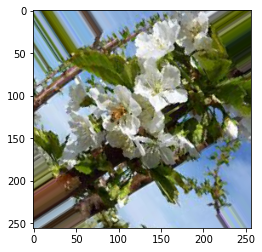

Blueberries


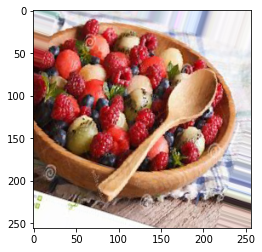

Blueberries


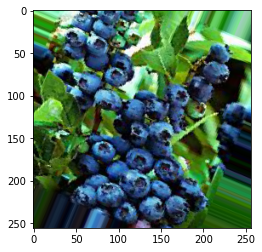

Blueberries


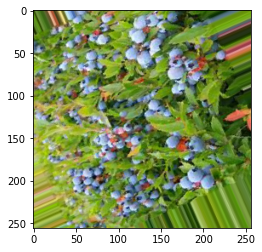

Blueberries


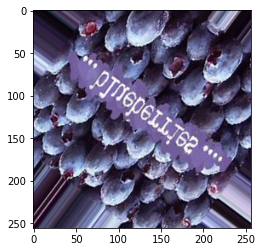

Blueberries


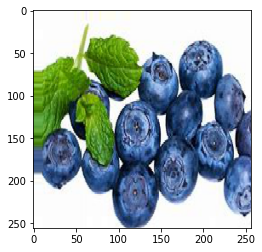

Blueberries


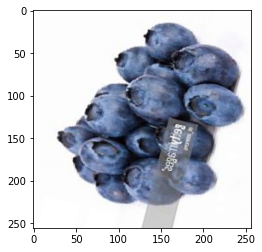

Blueberries


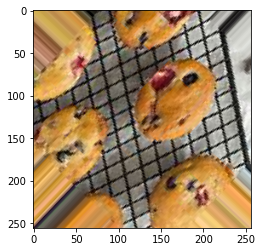

Blueberries


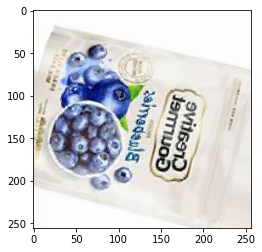

Blueberries


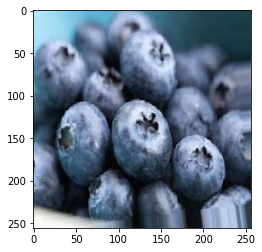

In [ ]:
"""# Show some examples"""

x,y = train_generator.next()

for i in range(0,10):
    image = x[i]
    label = y[i].argmax() 
    print(classnames[label])
    plt.imshow(image)
    plt.show()

# TRAINING

LOAD MODEL TO CONTINUE TRAINING IF NECESSARY

In [ ]:
from keras.models import load_model
model_path = ('Models/...')
model = load_model(model_path)

## TRANSFER LEARNING

TRANSFER VGG16

In [ ]:
"""# Create the transfer-model"""

#feature extraction
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=train_generator.image_shape,
                                               include_top=False,
                                               weights='imagenet')
pretrained_model.trainable = False

#COMPLETE MODEL WITH PERSONAL LAYERS
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2056      
Total params: 23,105,608
Trainable params: 8,390,920
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
import time

#Total number of steps (batches of samples) to yield from generator before declaring one epoch finished
steps = train_generator.n//train_generator.batch_size

start = time.time()
try:
    history = model.fit(train_generator, epochs=50, verbose=1,
                    steps_per_epoch = steps,
                    validation_data = test_generator,
                    validation_steps = test_generator.n//test_generator.batch_size,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True)]
                    )
except KeyboardInterrupt:
    pass
end = time.time()
enc_time = end-start

print('Execution time:')
print(str(enc_time))
print()

"""# Save the model"""

filename = os.path.join('Models', 'vgg16 - 256x256 - transf - adam - data aug - 46epoch.h5')
model.save(filename)
print("\nModel saved successfully on file %s\n" %filename)

Epoch 1/50
114/114 [==============================] - 140s 1s/step - loss: 1.4434 - accuracy: 0.1982 - val_loss: 0.2710 - val_accuracy: 0.4498
Epoch 2/50
114/114 [==============================] - 137s 1s/step - loss: 0.3489 - accuracy: 0.3721 - val_loss: 0.2533 - val_accuracy: 0.5809
Epoch 3/50
114/114 [==============================] - 138s 1s/step - loss: 0.3199 - accuracy: 0.4212 - val_loss: 0.2321 - val_accuracy: 0.6250
Epoch 4/50
114/114 [==============================] - 137s 1s/step - loss: 0.2990 - accuracy: 0.4608 - val_loss: 0.2173 - val_accuracy: 0.6507
Epoch 5/50
114/114 [==============================] - 137s 1s/step - loss: 0.2954 - accuracy: 0.4705 - val_loss: 0.2028 - val_accuracy: 0.5926
Epoch 6/50
114/114 [==============================] - 137s 1s/step - loss: 0.2687 - accuracy: 0.5184 - val_loss: 0.2007 - val_accuracy: 0.6473
Epoch 7/50
114/114 [==============================] - 138s 1s/step - loss: 0.2647 - accuracy: 0.5321 - val_loss: 0.1905 - val_accuracy: 0.7227

## DEEP CNN FROM SCRATCH

ALEXNET

In [ ]:
"""# Create the first model"""

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras import regularizers


def AlexNet(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
                     strides=(2,2), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # D1 Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
# create the model
model = AlexNet(train_generator.image_shape, train_generator.num_classes)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 59, 59, 96)        34944     
_________________________________________________________________
activation_18 (Activation)   (None, 59, 59, 96)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 29, 96)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 29, 29, 96)        384       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 19, 19, 256)       2973952   
_________________________________________________________________
activation_19 (Activation)   (None, 19, 19, 256)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 9, 256)        

In [ ]:
"""# Train the model"""

import time

#Total number of steps (batches of samples) to yield from generator before declaring one epoch finished
steps = train_generator.n//train_generator.batch_size

start = time.time()
try:
    history = model.fit(train_generator, epochs=200, verbose=1,
                    steps_per_epoch = steps,
                    validation_data = test_generator,
                    validation_steps = test_generator.n//test_generator.batch_size,
                    )
except KeyboardInterrupt:
    pass
end = time.time()
enc_time = end-start

print('Execution time:')
print(str(enc_time))
print()

"""# Save the model"""

filename = os.path.join('Models', 'alex - 128x128 adam - .h5')
model.save(filename)
print("\nModel saved successfully on file %s\n" %filename)

Epoch 1/200
114/114 [==============================] - 56s 480ms/step - loss: 3.4107 - accuracy: 0.1314 - val_loss: 3.1067 - val_accuracy: 0.1412
Epoch 2/200
114/114 [==============================] - 53s 464ms/step - loss: 2.9348 - accuracy: 0.1220 - val_loss: 2.7048 - val_accuracy: 0.1066
Epoch 3/200
114/114 [==============================] - 53s 468ms/step - loss: 2.7943 - accuracy: 0.1134 - val_loss: 2.6936 - val_accuracy: 0.1523
Epoch 4/200
114/114 [==============================] - 53s 465ms/step - loss: 2.6874 - accuracy: 0.1335 - val_loss: 2.6314 - val_accuracy: 0.1172
Epoch 5/200
114/114 [==============================] - 53s 469ms/step - loss: 2.5891 - accuracy: 0.1377 - val_loss: 2.4962 - val_accuracy: 0.1183
Epoch 6/200
114/114 [==============================] - 53s 469ms/step - loss: 2.5040 - accuracy: 0.1124 - val_loss: 2.4903 - val_accuracy: 0.0731
Epoch 7/200
114/114 [==============================] - 54s 472ms/step - loss: 2.4346 - accuracy: 0.1191 - val_loss: 2.3570 -

## SMALL CNN FROM SCRATCH

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

def LeNet(input_shape, num_classes):
    
    print('\nLeNet model')
    model = Sequential()
    
    print('\tC1: Convolutional 6 kernels 5x5')
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding='same'))
    print('\tS2: Average Pooling 2x2 stride 2x2')
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    print('\tC3: Convolutional 16 kernels 5x5')
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    print('\tS4: Average Pooling 2x2 stride 2x2')
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    print('\tC5: Convolutional 120 kernels 5x5')
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(Flatten())
    print('\tF6: Fully connected, 84 units')
    model.add(Dense(84, activation='tanh'))
    print('\tF7: Fully connected, 10 units')
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = 'adam' #alternative 'SGD'
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

LENET MOD

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

def LeNet(input_shape, num_classes):
    
    print('\nLeNet model')
    model = Sequential()
    
    print('\tC1: Convolutional 6 kernels 5x5')
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same'))
    print('\tS2: Average Pooling 2x2 stride 2x2')
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    print('\tC3: Convolutional 16 kernels 5x5')
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    print('\tS4: Average Pooling 2x2 stride 2x2')
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    print('\tC5: Convolutional 120 kernels 5x5')
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    model.add(Flatten())
    print('\tF6: Fully connected, 84 units')
    model.add(Dense(84, activation='relu'))
    print('\tF7: Fully connected, 10 units')
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = 'SGD' #alternative 'adam'
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [ ]:
# create the model
model = LeNet(train_generator.image_shape, train_generator.num_classes)
model.summary()


LeNet model
	C1: Convolutional 6 kernels 5x5
	S2: Average Pooling 2x2 stride 2x2
	C3: Convolutional 16 kernels 5x5
	S4: Average Pooling 2x2 stride 2x2
	C5: Convolutional 120 kernels 5x5
	F6: Fully connected, 84 units
	F7: Fully connected, 10 units
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 6)       456       
_________________________________________________________________
average_pooling2d_4 (Average (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 16)        2416      
_________________________________________________________________
average_pooling2d_5 (Average (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 120)       48120     
___

In [ ]:
"""# Train the model"""

import time

#Total number of steps (batches of samples) to yield from generator before declaring one epoch finished
steps = train_generator.n//train_generator.batch_size

start = time.time()
try:
    history = model.fit(train_generator, epochs=100, verbose=1,
                    steps_per_epoch = steps,
                    validation_data = test_generator,
                    validation_steps = test_generator.n//test_generator.batch_size,
                    #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True)]
                    )
except KeyboardInterrupt:
    pass
end = time.time()
enc_time = end-start

print('Execution time:')
print(str(enc_time))
print()

"""# Save the model"""

filename = os.path.join('Models', 'lenet.h5')
model.save(filename)
print("\nModel saved successfully on file %s\n" %filename)

Epoch 1/100
114/114 [==============================] - 19s 166ms/step - loss: 2.1816 - accuracy: 0.1188 - val_loss: 2.0781 - val_accuracy: 0.1395
Epoch 2/100
114/114 [==============================] - 18s 157ms/step - loss: 2.0814 - accuracy: 0.0775 - val_loss: 2.0753 - val_accuracy: 0.1635
Epoch 3/100
114/114 [==============================] - 18s 155ms/step - loss: 2.0724 - accuracy: 0.1342 - val_loss: 2.0754 - val_accuracy: 0.1445
Epoch 4/100
114/114 [==============================] - 18s 157ms/step - loss: 2.0767 - accuracy: 0.1092 - val_loss: 2.0749 - val_accuracy: 0.1484
Epoch 5/100
114/114 [==============================] - 18s 156ms/step - loss: 2.0687 - accuracy: 0.1037 - val_loss: 2.0434 - val_accuracy: 0.2310
Epoch 6/100
114/114 [==============================] - 18s 158ms/step - loss: 2.0631 - accuracy: 0.1896 - val_loss: 2.0185 - val_accuracy: 0.2154
Epoch 7/100
114/114 [==============================] - 18s 156ms/step - loss: 2.0398 - accuracy: 0.1666 - val_loss: 1.9869 -

In [ ]:
import time

#Total number of steps (batches of samples) to yield from generator before declaring one epoch finished
steps = train_generator.n//train_generator.batch_size

start = time.time()
try:
    history_fine = model.fit(train_generator,
                         epochs=100, verbose = 1,
                         steps_per_epoch = steps, 
                         initial_epoch=history.epoch[-1],
                         validation_data = test_generator,
                         validation_steps = test_generator.n//test_generator.batch_size
                    )
except KeyboardInterrupt:
    pass
end = time.time()
enc_time = end-start

print('Execution time:')
print(str(enc_time))
print()

"""# Save the model"""

filename = os.path.join('Models', 'vgg16-plus.h5')
model.save(filename)
print("\nModel saved successfully on file %s\n" %filename)

Epoch 25/100
114/114 [==============================] - 50s 436ms/step - loss: 0.2068 - accuracy: 0.6526 - val_loss: 0.1633 - val_accuracy: 0.7355
Epoch 26/100
114/114 [==============================] - 48s 424ms/step - loss: 0.2027 - accuracy: 0.6622 - val_loss: 0.1543 - val_accuracy: 0.7545
Epoch 27/100
114/114 [==============================] - 48s 421ms/step - loss: 0.1957 - accuracy: 0.6716 - val_loss: 0.1492 - val_accuracy: 0.7595
Epoch 28/100
114/114 [==============================] - 48s 423ms/step - loss: 0.1986 - accuracy: 0.6675 - val_loss: 0.1532 - val_accuracy: 0.7299
Epoch 29/100
114/114 [==============================] - 48s 419ms/step - loss: 0.2010 - accuracy: 0.6649 - val_loss: 0.1485 - val_accuracy: 0.7617
Epoch 30/100
114/114 [==============================] - 48s 420ms/step - loss: 0.1986 - accuracy: 0.6634 - val_loss: 0.1552 - val_accuracy: 0.7455
Epoch 31/100
114/114 [==============================] - 48s 419ms/step - loss: 0.2003 - accuracy: 0.6613 - val_loss: 0

# EVALUATION

## TRAINING EVALUATION

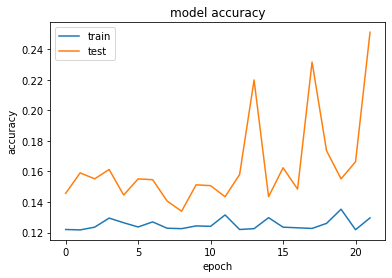

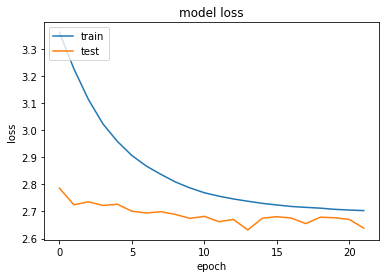

In [ ]:
"""Graphs"""

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

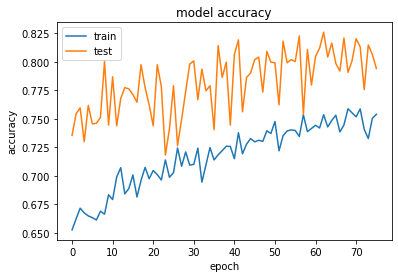

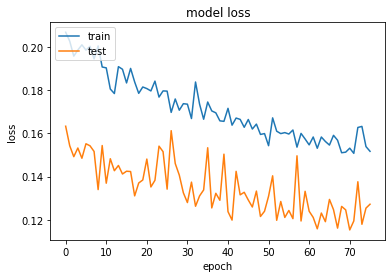

In [ ]:
"""Graphs 2"""

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

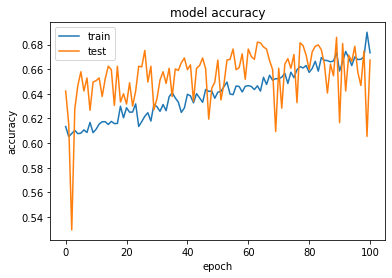

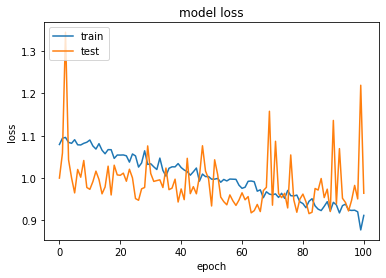

In [ ]:
"""Graphs 3"""

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history_fine_2.history['accuracy'])
plt.plot(history_fine_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_fine_2.history['loss'])
plt.plot(history_fine_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

LOAD MODEL FROM PREV TRAINING IF NECESSARY

In [ ]:
from keras.models import load_model
model = load_model('Models/vgg16 - 256x256 - transf - adam - data aug - 46epoch - tbc.h5')

In [ ]:
"""Accuracy on test set"""

val_steps = test_generator.n//test_generator.batch_size + 1
loss, acc = model.evaluate(test_generator, verbose=1, steps = val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

29/29 [==============================] - 28s 941ms/step - loss: 0.1227 - accuracy: 0.8226
Test loss: 0.122666
Test accuracy: 0.822625


In [ ]:
"""Precision, recall, F-score"""

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

print('Loaded %d test samples from %d classes.' %(test_generator.n, test_generator.num_classes))

preds = model.predict(test_generator, verbose=1, steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes 

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

Loaded 1821 test samples from 8 classes.
29/29 [==============================] - 28s 969ms/step
                          precision    recall  f1-score   support

             Blueberries      0.926     0.855     0.889       220
            Energy_Drink      0.817     0.854     0.835       246
                   Honey      0.612     0.822     0.702       259
            Latex_Gloves      0.880     0.796     0.836       211
Vegetable_Chips_&_Crisps      0.763     0.871     0.813       240
            accent_plate      0.964     0.879     0.919       214
             grocery_bag      0.889     0.621     0.731       219
           plastic_knife      0.925     0.873     0.898       212

                accuracy                          0.822      1821
               macro avg      0.847     0.821     0.828      1821
            weighted avg      0.840     0.822     0.825      1821



In [ ]:
"""confusion matrix"""

cm = confusion_matrix(Ytest, Ypred)
print(cm)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])] 

print('\nConfusion matrix analysis' )
print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s        ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

[[188   0   6   0  23   1   1   1]
 [  0 210  26   3   5   1   0   1]
 [  2  23 213   3  12   2   3   1]
 [  0  15  14 168   9   0   5   0]
 [ 11   0  17   1 209   0   2   0]
 [  2   2  11   2   1 188   3   5]
 [  0   3  49   7  14   3 136   7]
 [  0   4  12   7   1   0   3 185]]

Confusion matrix analysis
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
grocery_bag             ->  Honey             	49 	2.69 % 
Energy_Drink            ->  Honey             	26 	1.43 % 
Blueberries             ->  Vegetable_Chips_&_Crisps  	23 	1.26 % 
Honey                   ->  Energy_Drink      	23 	1.26 % 
Vegetable_Chips_&_Crisps        ->  Honey             	17 	0.93 % 
Latex_Gloves            ->  Energy_Drink      	15 	0.82 % 
grocery_bag             ->  Vegetable_Chips_&_Crisps  	14 	0.77 % 
Latex_Gloves            ->  Honey             	14 	0.77 % 
plastic_knife           ->  Honey             	12 	0.66 % 
Honey          